# Potts Model and Phase Transitions

Authors: Scardecchia Mattia, Filatrella Dario

Date: 07/06/2023

# Introduction

In this project, we are going to study the phase transition of the ferromagnetic Potts model on a square lattice.

The Potts model is a generalization of the Ising model and consists of a system of interacting spins that can be in either of $q$ states. Spins are located on a two-dimensional square lattice of length $L$, and neighbouring spins interact according to the Hamiltonian: $$ H(s_1, ..., s_N) = - J \sum_{(ij)} \delta (s_i, s_j) ,$$
where the summation is over all pairs of neighbouring spins on the lattice (with periodic boundary conditions). $J$ is a positive constant and it represents the strength of the ferromagnetic interaction.

Using the statistical physics approach, we can study the maximally entropic Boltzmann distribution $$ p(s_1, ..., s_N) = \frac{1}{Z(\beta)} \exp \left( - \beta H(s_1, ..., s_N) \right) ,$$
where $\beta$ is the inverse temperature and $Z(\beta)$ is the partition function and it can be used to derive all the thermodynamic averages of the system, if an analytical expression is available.

It is well known ( <a href="https://arxiv.org/abs/1611.09877"> Duminil-Copin et al. </a>, <a href="https://arxiv.org/abs/1505.04159"> Duminil-Copin et al. </a>) that this model exhibits a phase transition in the thermodynamic limit ($N \to \infty$) at: $$ \beta J = \log \left( 1 + \sqrt{q} \right) .$$ The transition is continuous for $q \le 4$, and discontinuous for $q > 4$. The system goes from an ordered state, below the critical temperature, in which energy wins the trade-off with entropy and spins spontaneously allign, to a disordered state in which entropy wins and the ensemble is dominated by configurations in which there is no global order, and spins tend to point in random directions.
These results were obtained analytically. For our project, we want to use Monte Carlo methods, and in particular the Metropolis algorithm, to compute thermodynamic averages of the system and study numerically the phase transition.

In order to do this, we computed the average energy, magnetization and specific heat of the system at different temperatures, and we plotted the results to examine the behaviour around the theoretical critical temperature. Since the phase transition exists in the thermodynamic limit, we used increasing values of $L$ to detect potential finite-size effects.

The main challenge was the necessity to simulate a large system many times to explore the dependency of the thermodynamic averages on temperature, which is computationally very expensive. To overcome this challenge, we had to resort to a series of optimizations that made our code run orders of magnitude faster than a naive Python implementation.

As we will show, our numerical results pin down the critical temperature to a good accuracy, and already with small lattice sizes  we do observe a phase transition, which is significantly sharper for $q > 4$ than for $q \le 4$.

# Code for simulations

To compute numerically thermodynamic averages we used the Metropolis-Hastings algorithm, proposing random spin flips at every step, one at a time. We show here the implementation, explaining in detail what each function does. As remarked, computational efficiency was a crucial aspect, and we had to make a few changes from the most intuitive and simple python implementation, which we now explain.
First, we used native Python lists instead of numpy arrays. In fact, since we were not making any use of the vector operations of numpy but just accessing elements, those arrays were slower than lists. This change gave a speedup of about x3.
Second, to spare memory we did not save the energy and magnetizations at every instant, but rather we kept a running average along the trajectory. More precisely, what we did was to maintain the sum of the metrics along the trajectory, and normalize by its length at the end. The reason for this was numerical stability: it allowed us to work with Python integers, which have no upperlimit and tolerate well sums involving numbers of different orders of magnitude.
Third, we ran the simulation on multiple processes in order to make python use all the cores of our cpu. The speed-up in this case was almost linear with the number of cores used (below the number of cores of our cpu).
Finally, we did not run the code on Cpython but on PyPy, a JIT compiler for python. This allowed us to get a speed-up of about 8x.

In [1]:
import json
import math
import platform
import random
import time

# we set the seed only once for reproducibility
random.seed(2212)


def energy_nn(sigma, J, L) -> int:
    """This function computes the total energy of the configuration. It iterates over the whole lattice, and it is in practice used only once as there is a faster way to update energies.
    ----------
    sigma: the configuration of the lattice,
    J: the coupling constant,
    L: the size of the side of the lattice,
    """
    en = 0
    for i in range(L):
        for j in range(L):
            if sigma[i][j] == sigma[i][(j + 1) % L]: en -= J
            if sigma[i][j] == sigma[(i + 1) % L][j]: en -= J
    return en


def delta_energy_nn(sigma, J, i, j, new_q, L) -> int:
    """This function computes the difference in energy if one were to change a single spin. It is used in every step of the metropolis algorithm. It only looks at the neighbors of the flipped spin.
    ----------
    sigma: the configuration of the lattice,
    J: the coupling constant,
    new_q: the new spin state,
    i, j: the coordinates of the spin to be flipped,
    L: the size of the side of the lattice,
    """

    neighs = [(i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j)]
    delta_en = 0
    for x, y in neighs:
        if sigma[i][j] == sigma[x][y]:
            delta_en += J
        if new_q == sigma[x][y]:
            delta_en -= J
    return delta_en


def propose_flip(sigma, J, L, N, q) -> (int, int, int):
    """This function proposes a spin flip. It is used in every step of the metropolis algorithm. It returns the coordinates of the spin to be flipped and the new spin value. It is guaranteed that the new spin value is different from the old one.
    ----------
    sigma: the configuration of the lattice,
    J: the coupling constant,
    L: the size of the side of the lattice,
    q: the number of possible spin states,
    N: the size of the lattice,
    """
    index = random.randint(0, N - 1)
    index1, index2 = index // L, index % L

    x = random.randint(0, q - 1)
    while x == sigma[index1][index2]:
        x = random.randint(0, q - 1)
    return index1, index2, x


def metropolis(delta_en, t) -> bool:
    """This function computes the acceptance probability and then decides whether to accept the flip or not by generating a random number.
    ----------
    delta_en: the difference in energy between the new and the old configuration,
    t: the temperature,
    """
    if delta_en < 0:
        return True
    if random.uniform(0, 1) < math.exp(- delta_en / t):
        return True
    return False


def bincount(x, q, double=True) -> list:
    """Replaces np.bincount. It counts the number of appearences of each integer between 0 and q-1 in the list x. Performance on this is not critical as it is run only at the beginning of each simulation and then the number of spins of each type is updated at every step.
    ----------
    x: the list to be counted,
    q: the number of possible spin states,
    double: whether x is a lattice or a list of spins,"""

    # flatten double list
    if double:
        flattened = []
        for sublist in x:
            for item in sublist:
                flattened.append(item)
        x = flattened
    # count appearences of integers between 0 and q-1 (error raised if q is wrong)
    counts = [0] * q
    for i in x:
        counts[i] += 1
    return counts

In [36]:
def MCMC(L, q, t, nstep, burnin, J=1):
    """This function runs the Metropolis algorithm for a given number of steps. It returns the average magnetization and the average energy.
    ----------
    L: the size of the side of the lattice,
    q: the number of possible spin states,
    t: the temperature,
    nstep: the number of steps to be run,
    burnin: the number of steps to be run before starting to collect data,
    J: the coupling constant,
    """

    # random initial configuration
    N = L ** 2
    sigma = [[random.randint(0, q - 1) for _1 in range(L)] for _2 in range(L)]

    # initial energy
    en = energy_nn(sigma, J, L)

    # run burnin steps to reach stationarity
    for istep in range(burnin):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J, L, N, q)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new, L)
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new
            # update energy
            en += delta_en

    # initialize magnetization averaging
    magnetization_state = bincount(sigma, q)
    max_magnetization_avg = 0

    # initialize energy averaging
    energy_avg = 0

    # main loop
    for istep in range(nstep):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J, L, N, q)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new, L)

        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new

            # update energy
            en += delta_en
            # update magnetization history
            magnetization_state[q_old] -= 1
            magnetization_state[q_new] += 1

        # update averages
        max_magnetization_avg += max(magnetization_state)
        energy_avg += en

    # normalize and return averages
    return energy_avg / nstep, max_magnetization_avg / nstep / N

In [37]:
# utility functions to decide range of temperatures to test against and generate the list

def critical_Temperature(q, J=1):
    return J / math.log(1 + math.sqrt(q))


# values that we changed to run different tests
n2 = 1
n1 = 3
dt = 0.005


def arange(start, stop, step):
    """Replaces numpy.arange"""
    result = []
    eps = 0.001
    current = start
    while current < stop - eps:
        result.append(current)
        current += step
    return result


def get_temps(q, J=1, n1=n1, n2=n2, dt=dt, zero=0.4, infinity=3.0):
    """Generates 3 lists, one for low temperature with few intervals, one for temperatures around the critical T with many intervals and one for high temperatures with few intervals.
    ----------
    q: the number of possible spin states,
    J: the coupling constant,
    n1: the number of intervals around the critical temperature,
    n2: the number of intervals for low and high temperatures,
    dt: the size of the intervals around the critical temperature,
    zero: the lower bound of the low temperature interval,
    infinity: the upper bound of the high temperature interval,
    """

    crit = critical_Temperature(q, J)
    crit = round(crit, 4)

    low = crit - n1 * dt
    high = crit + n1 * dt

    # compute the 3 lists
    core = arange(low, high, dt)
    out1 = arange(zero, low, (low - zero) / n2)
    out2 = arange(high, infinity, (infinity - high) / (n2 + 1))

    # cut one of the lists to avoid overlaps
    core = list(core)
    out1 = list(out1)[:-1]
    out2 = list(out2)

    # round to 4 decimals
    for arr in [core, out1, out2]:
        for i, x in enumerate(arr):
            arr[i] = round(x, 4)

    return out1, core, out2

In [4]:
def simulate(L, q):
    """This function runs a full simulation at all the temperatures given q and L
    ----------
    L: the size of the side of the lattice,
    q: the number of possible spin states,
    ----------
    returns a list of the temperatures, a list of the average energy and a list of the average magnetization for each temperature
    """
    avg_en = []
    avg_mag = []

    temps_triple = get_temps(q)

    ordered_temps = []

    # these were adjusted depending on the values of L and q simulated, to ensure convergence.
    steps = (4 * 10 ** 7, 10 ** 8, 4 * 10 ** 7)
    burnin = (4 * 10 ** 7, 10 ** 8, 4 * 10 ** 7)

    for temps, step, burn in zip(temps_triple, steps, burnin):
        for t in temps:
            tempo = time.time()
            ordered_temps.append(t)
            if abs(t - critical_Temperature(q)) < 0.05:
                print(f"Starting simulation for {q=} {L=} {t=} with step={4 * 10 ** 8} and burnin={2 * 10 ** 8}")
                en, mag = MCMC(L, q, t, 5 * 10 ** 8, 2 * 10 ** 8)
            else:
                print(f"Starting simulation for {q=} {L=} {t=} with step={step} and burnin={burn}")
                en, mag = MCMC(L, q, t, step, burn)
            avg_en.append(en)
            avg_mag.append(mag)
            print(f"Elapsed time: {time.time() - tempo}")

    return ordered_temps, avg_en, avg_mag


def simulate_save(inp):
    """This function wraps the previous simulation, computes the specific heats and saves the results in a json file
    ----------
    inp: a tuple containing (q, L)"""

    # the reason for the tuple is to easily run a multiprocess Pool
    q, L = inp
    tempo = time.time()

    # due to the length of the simulation we log some information to keep track of the progress
    print(f"Simulating {q=} {L=}")
    temps, avg_en, avg_mag = simulate(L, q)
    print(f"Elapsed time: {time.time() - tempo}")

    # compute specific heat by finite differences at the midpoints of the temperature intervals
    spec_heat = [(avg_en[i + 1] - avg_en[i]) / (temps[i + 1] - temps[i]) for i in range(0, len(temps) - 1)]
    spec_heat_temps = [(temps[i + 1] + temps[i]) / 2 for i in range(0, len(temps) - 1)]

    for i, x in enumerate(spec_heat_temps):
        spec_heat_temps[i] = round(x, 3)

    with open(f"simulation_{q=}_{L=}.json", "w") as file:
        json.dump({"temps": temps, "avg_en": avg_en, "avg_mag": avg_mag,
                   "spec_heat": spec_heat, "spec_heat_temps": spec_heat_temps}, file)


In [5]:
# Warning: this cell takes a long time to run
import multiprocessing as mp

run_cell = False

# this list was changed during the simulations to run different tests
qs_Ls = [
    (4, 50),
    (5, 50),
]

# the Pool size depends on the CPU
if run_cell:
    with mp.Pool(4) as p:
        p.map(simulate_save, qs_Ls)

# Monte Carlo Simulations

In this section, we show an example run of the Metropolis algorithm. This is meant to demonstrate how we gather metrics, how we plot their evolution in time, and how we investigate the choice of hyperparameters such as the number of iterations. In order to perform the experiments that we will describe in the next section, we used extensively the precedure outlined in this section to inform our choices and gain intuition into the behaviour of the system.

The code that we use in this portion is almost identical to that showcased in the last section, except for a few changes that make it easier to use interactively in a notebook, at the cost of some efficiency. To make this section self-contained and easy to re-run, we redefine all functions at the beginning, although many have remained unchanged compared to the previous section.

In [7]:
# import useful libraries
import time, random, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# global parameters
L = 20                  # side length
N = L ** 2              # number of sites
q = 4                   # number of states per site
J = 1                   # ferromagnetic interaction strength

# store metrics
en_historys = {}        # energy
mag_historys = {}       # magnetization
prob_historys = {}      # acceptance probability
n_accepteds = {}        # fraction of accepted

In [8]:
# function definitions for interactive experiments

# compute energy of a configuration sigma
def energy_nn(sigma, J):
    en = 0
    for i in range(L):
        for j in range(L):
            if sigma[i][j] == sigma[i][(j + 1) % L]: en -= J
            if sigma[i][j] == sigma[(i + 1) % L][j]: en -= J
    return en


# compute energy variation starting from configuration sigma and flipping the spin in position (i, j) to state new_q
def delta_energy_nn(sigma, J, i, j, new_q):
    neighs = ((i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j))
    delta_en = 0
    for x, y in neighs:
        if sigma[i][j] == sigma[x][y]:
            delta_en += J
        if new_q == sigma[x][y]:
            delta_en -= J
    return delta_en


# sample a random flip in a random position given the current configuration sigma
def propose_flip(sigma, J=1):
    idx = random.randint(0, N-1)
    i, j = idx // L, idx % L
    x = random.randint(0, q-1)
    while x == sigma[i][j]:
        x = random.randint(0, q-1)
    return i, j, x


# metropolis acceptance with symmetric proposal. returns a Boolean
def metropolis(delta_en, t):
    if delta_en < 0:
        return True
    if random.uniform(0, 1) < math.exp(- delta_en / t):
        return True
    return False


# useful function that computes the theoretical critical temperature as function of q
def critical_temperature(q, J=1):
    return J / np.log(1 + np.sqrt(q))

In [9]:
# metropolis simulation. Accept parameters specifying system and simulation config. Store results in global dicts.

def MCMC(L, q, t, nstep, burnin, J=1, stride=None):

    random.seed(42)

    # sample metrics every stride steps, to save memory if simulation is long
    if stride is None:
        stride = 1

    # random initial configuration
    sigma = [[random.randint(0, q-1) for _1 in range(L)] for _2 in range(L)]
    en = energy_nn(sigma, J)

    # run a few steps to reach stationarity
    for istep in range(burnin):
        # propose random flip
        i, j, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, i, j, q_new)
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            sigma[i][j] = q_new
            # update energy
            en += delta_en

    # prepare to store metrics
    mag_history = [[0 for x in range(q)] for y in range(nstep // stride + 1)]
    mag_history[0] = list(np.bincount(np.array(sigma).reshape(-1), minlength=q))
    prob_history = []
    en_history = []
    n_accepted = 0

    # main loop
    for istep in range(nstep):
        # propose random flip
        i, j, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, i, j, q_new)
        if istep % stride == 0:
            # update probability history
            if delta_en > 0:
                prob_history.append(math.exp(- delta_en / t))
            else:
                prob_history.append(1)
            # prepare magnetization update
            mag_history[istep//stride + 1] = mag_history[istep//stride].copy()
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[i][j]
            sigma[i][j] = q_new
            n_accepted += 1
            # update energy
            en += delta_en
            # update magnetization history independently os istep % stride (for accurate magnetization in the future)
            mag_history[istep//stride + 1][q_old] -= 1
            mag_history[istep//stride + 1][q_new] += 1
        # update energy history
        if istep % stride == 0:
            en_history.append(en)

    # save metrics inside global dicts
    en_historys[t] = np.array(en_history)
    mag_historys[t] = np.array(mag_history)[:-1, :]  # to have shape (nstep, q)
    prob_historys[t] = np.array(prob_history)
    n_accepteds[t] = n_accepted

For a detailed explanation of what each function does, and the reasons behind our implementation choices, please go back to the previous section.

___

To have an idea of what a sensible choice of temperature might be, let's see what the theoretical critical temperature is. Since we're at it, let's also plot it against a range of values of $q$.

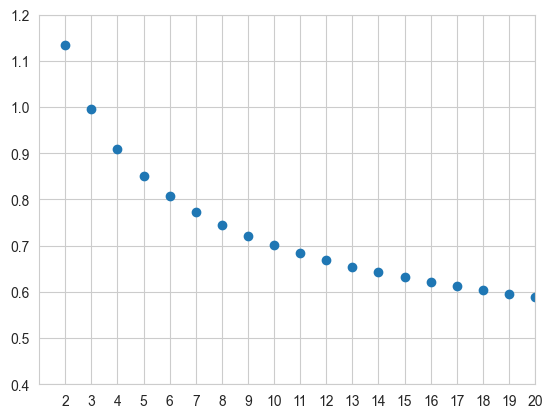

In [5]:
# range of values of q
qs = np.arange(2, 21)

# critical temperatures
crits = critical_temperature(qs)

# plot
plt.plot(qs, crits, 'o')
plt.ylim(0.4, 1.2)
plt.xlim(1, 20)
plt.xticks(qs)
plt.grid(True)
plt.show()

This should provide a rough idea of what the order of magnitude of the temperature should be. To get an even better intuition for that, we can look at typical values of the energy and, crucially, typical variations in energy when a spin gets flipped.

The change in energy due to a spin flip (our chosen move in the metropolis scheme) is $O(J) = O(1)$. This means that when the temperature $t >> 1$, all flips get accepted, irrespective of whether they increase or decrease energy, while when $t << 1$ only moves that decrease energy get accepted. Sensible values of the temperature are such that $t = O(1)$, which is in agreement with what we had established looking at the critical temperature.

To quickly check this numerically, we can run a simple experiment using a random spin configuration.

In [ ]:
q = 4
L = 20
N = L**2
J = 1

print("q: ", q)
print("critical temperature: ", critical_temperature(q))

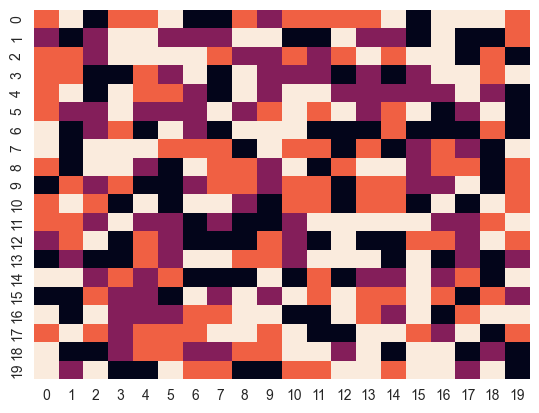

In [10]:
# for reproducibility
np.random.seed(42)

# generate and show a random spin configuration
sigma = np.random.randint(0, q, (L, L))
sns.heatmap(sigma, cbar=False)
plt.show()

In [7]:
ts = [0.1, 1.0, 10.0]
iters = 100
energies = []
probas = {t: [] for t in ts}

# sample random flips many times and compute energy variation and acceptance probability for each
for _ in range(iters):
    # random spin flip from starting config
    i, j, q_new = propose_flip(sigma)

    # energy variation
    delta_en = delta_energy_nn(sigma, J, i, j, q_new)
    energies.append(delta_en)

    # probability to accept with different temperatures
    for t in ts:
        prob = min(1, np.exp(- delta_en / t))
        probas[t].append(prob)

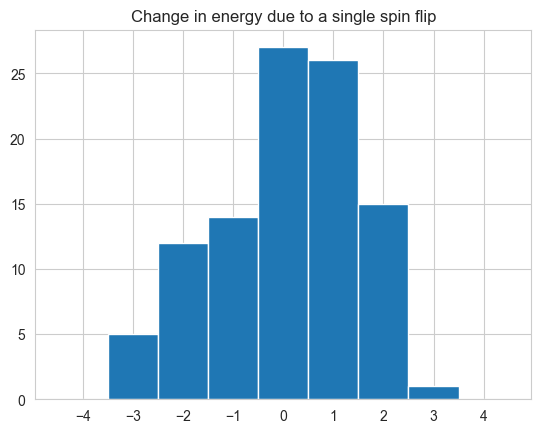

In [8]:
# print histogram of energy varations
bins = np.arange(-4.5, 5.5, 1)
plt.hist(energies, bins=bins)
plt.title("Change in energy due to a single spin flip")
plt.xticks(np.arange(-4, 5, 1))
plt.show()

Temperature:  0.1
Acceptance rate of uphill moves:  2.8105454552917126e-05


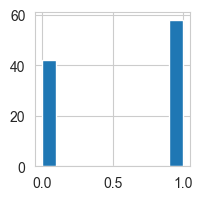

Temperature:  1.0
Acceptance rate of uphill moves:  0.27725432827082286


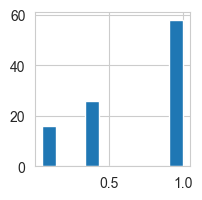

Temperature:  10.0
Acceptance rate of uphill moves:  0.8701798187092


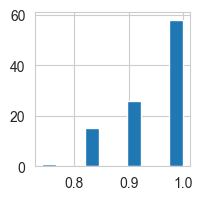

In [9]:
# print histogram of acceptance probabilities
for t in ts:
    probas[t] = np.array(probas[t])
    uphill = probas[t][probas[t] != 1]
    print("Temperature: ", t)
    print("Acceptance rate of uphill moves: ", sum(uphill) / len(uphill))
    plt.figure(figsize=(2, 2))
    plt.hist(probas[t])
    plt.show()

We see, as expected, that temperatures that are not $O(1)$ give extremely high or extremely low probabilities of accepting uphill moves.

___

With these considerations in mind, let's run an example metropolis simulation. Let's use a temperature of order 1, below the critical temperature. What we expect to see is that the spins polarize and one state dominates. Occasionally, if we wait long enough, we might observe that the state that dominates changes. The time for this to happen is exponential in the size of the system. For a system not too big, like ours, and for temperatures close enough to the critical temperature, this will happen within a reasonable time window.

An important remark. In principle, to fully explore the configuration space, we need to have all states dominate over the others at least once. However, for reasons of symmetry, it turns out that this is not necessary to obtain the correct estimate of the average energy and magnetization: as we will see, these averages become stationary long before all configurations have been explored.
 For a less symmetrical problem, like for instance a Potts model with random couplings, we would need to explore the whole configuration space to obtain reliable estimates of the ensemble averages. Given the glassy nature of the landscape of such a model, it would be impractical and probably ineffective, at temperatures lower than the critical temperature, to use the vanilla Metropolis algorithm. More sophisticated algorithms, like Simulated tempering, would be needed.

In order to make the plots look cleaner, in these interactive runs we only save metrics every 'stride' updates. This helps a lot with visualization, at a small cost, since states close in time along the chain are very correlated (given that our moves are a single spin flip).

In [10]:
L = 10
N = L**2
q = 4
t = 0.88
nstep = 10**7
burnin = 0
stride = 100

MCMC(L, q, t, nstep, burnin, J, stride)

Let's plot the fraction of spins that occupy each state, as function of time.

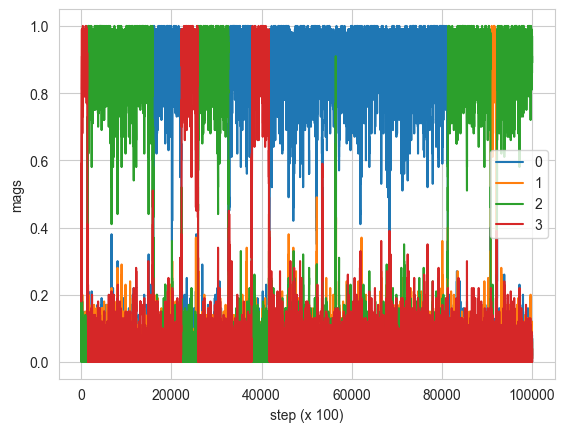

In [17]:
mag_history = mag_historys[t]

# print magnetization evolution in time
for i in range(q):
    plt.plot(mag_historys[t][:, i] / N, label=i)
plt.xlabel(f'step (x {stride})')
plt.ylabel('mags')
plt.legend()
plt.show()

As you can see from the plot, the system tends to polarize with one state dominating over the others. However, since the system is somewhat small (100 spins) and the temperature is pretty close to the critical temperature, the typical time that it takes to change the dominant state is short enough that we can observe that happening multiple times: we are fully exploring the state space.

To have a clearly defined 'magnetization', we consider the fraction of spins that occupy the most abundant state. Let's plot this as function of time.

Average magnetization: 0.8932756999999998


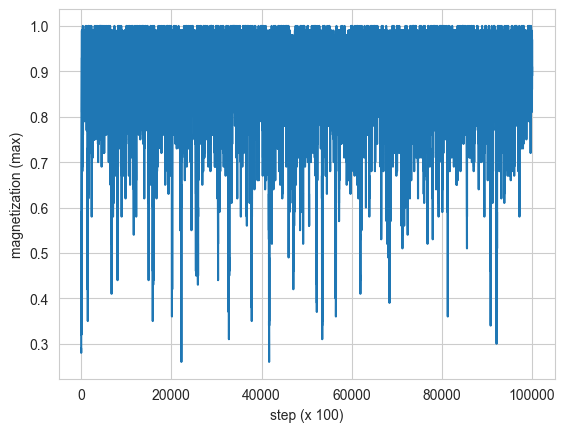

In [12]:
# print maximum absolute value of magnetization in time
max_mag = mag_history.max(axis=1) / N
plt.plot(max_mag)
plt.xlabel(f'step (x {stride})')
plt.ylabel('magnetization (max)')
print(f"Average magnetization: {max_mag.mean()}")
plt.show()

In order to check whether the estimate of a thermodynamic average has converged, we use a simple test. We bin time into a number of consecutive chunks, and we compute the average using observations from each chunk individually. A necessary condition to stop the simulation and consider the estimate good is that the averages computed this way should have become stable (of course, chunks must be big enough that fluctuations due to chance are small in order for this test to make any sense at all).

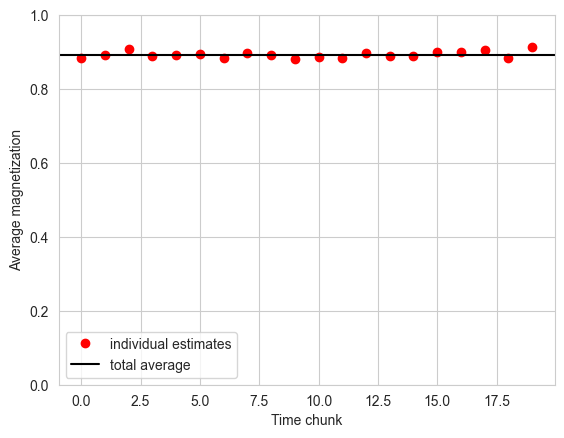

In [13]:
# compute average magnetization using consecutive chunks of time. Check stationarity
k = 20
cuts = [i * len(max_mag) // k for i in range(k+1)]
estimates = [max_mag[cuts[i]:cuts[i+1]].mean() for i in range(k)]

# plot
plt.plot(estimates, 'o', color='red', label='individual estimates')
plt.ylim(0, 1)
plt.xlabel('Time chunk')
plt.ylabel('Average magnetization')
plt.axhline(max_mag.mean(), color='black', label='total average')
plt.legend()
plt.show()

In this case, it seems that the average magnetization has reach convergence. It's value keeps fluctuating around 0.89. This is true already very early, when the system has not had a chance to explore the full state space yet (meaning that not all states have yet been dominant at least once), proving our point: thanks to symmetry, it's not necessary in this particular model to explore the whole configuration space in order to get reliable estimates of the average energy and magnetization. This is crucial with lower temperatures, for which similar changes in the dominant state are not observed within a reasonable time window (although even in that case, for q not too large, one could randomly reinitialize the chain multiple times to mitigate this issue).

Let's also plot the energy.

Average energy: -171.89215


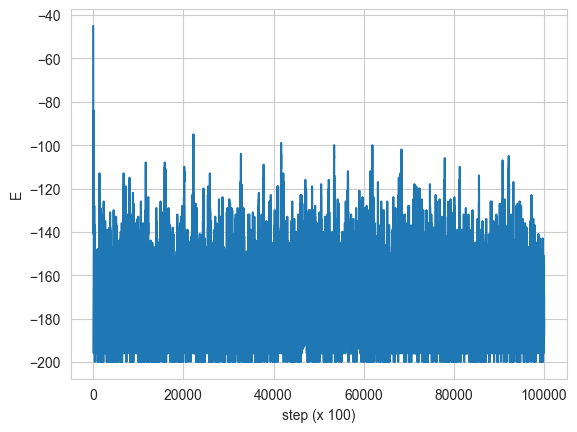

In [14]:
en_history = en_historys[t]

# plot energy evolution in time
plt.plot(en_history)
plt.xlabel(f'step (x {stride})')
plt.ylabel("E")

print(f'Average energy: {en_history.mean()}')
plt.show()

We do the same stationarity test that we did for the magnetization.

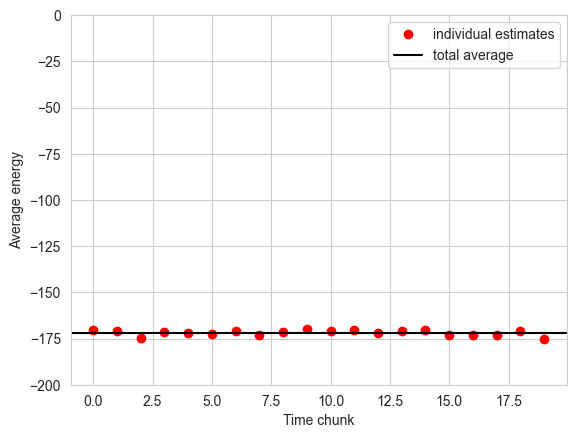

In [15]:
# compute average energy using consecutive chunks of time. Check stationarity
k = 20
cuts = [i * len(en_history) // k for i in range(k+1)]
estimates = [en_history[cuts[i]:cuts[i+1]].mean() for i in range(k)]

# plot
plt.plot(estimates, 'o', color='red', label='individual estimates')
plt.ylim(-200, 0)
plt.xlabel('Time chunk')
plt.ylabel('Average energy')
plt.axhline(en_history.mean(), color='black', label='total average')
plt.legend()
plt.show()

Conclusions are similar to the case of the magnetization.

Finally, we show the evolution of the acceptance probability in time. For the purpose of visualization, since it varies a lot, we smooth it out by plotting the average within a moving window.

Fraction of accepted proposals: 0.0993477


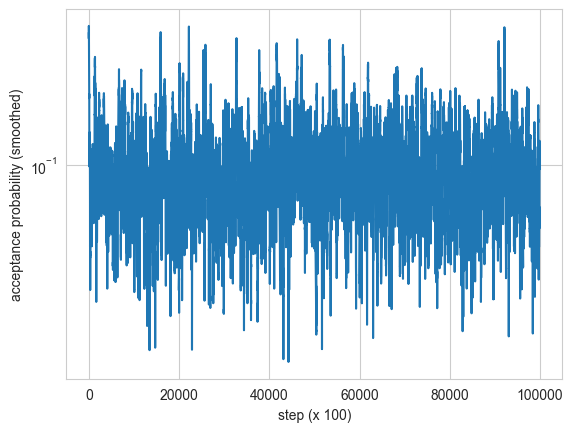

In [16]:
prob_history = prob_historys[t]
n_accepted = n_accepteds[t]

# convolve acceptance probabilities with a kernel to improve visualization
window_size = 100
kernel = np.ones(window_size) / window_size
smoothed_probs = np.convolve(prob_history, kernel, mode='valid')

# plot
plt.plot(smoothed_probs)
plt.xlabel(f'step (x {stride})')
plt.ylabel('acceptance probability (smoothed)')
plt.yscale('log')

print(f"Fraction of accepted proposals: {n_accepted / nstep}")
plt.show()

This kind of exploratory analysis was very important to inform our choices of hyperparameters in the subsequent experiments. In particular, it was crucial to understand how many iterations are needed in a given regime for the thermodynamic averages to reach stationarity.

___

Before moving on to our experiments, let us demonstrate very briefly how the behaviour of the system would change if we change some of the hyperparameters. In the interest of brevity, we do not include all the plots that we have done for the previous case, but we summarize the behaviour of the system by plotting the evolution of the magnetizations in time. Of course, the same code would work just fine.

First, let's simulate a bigger system at the same temperature. This should have the effect of making the time required for the dominant state to change much longer.

In [43]:
L = 30
N = L**2
q = 4
t = 0.88
nstep = 10**7
burnin = 0
stride = 100

MCMC(L, q, t, nstep, burnin, J, stride)

Average magnetization: 0.8783413999999999


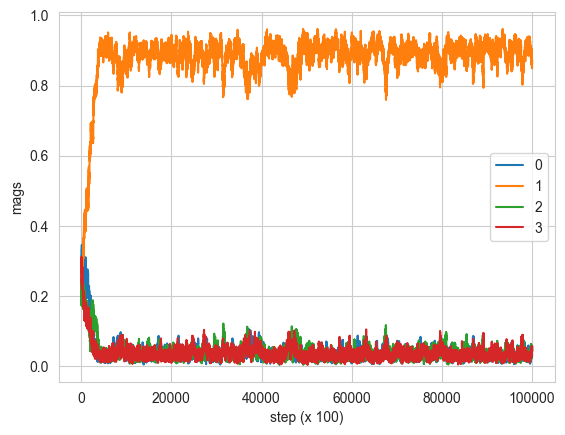

In [44]:
mag_history = mag_historys[t]

max_mag = mag_history.max(axis=1) / N
print(f"Average magnetization: {max_mag.mean()}")

# print magnetization evolution in time
for i in range(q):
    plt.plot(mag_historys[t][:, i] / N, label=i)
plt.xlabel(f'step (x {stride})')
plt.ylabel('mags')
plt.legend()
plt.show()

As expected, the system polarizes and the dominant state remains the same for the whole simulation. On a longer time-scale, however, the behaviour would be qualitatively similar to what we oberved for the smaller system.

Now, let us demonstrate the effects of varying the temperature, using the small system. With a small temperature far from the critical temperature, we would observe a behaviour similar to the case of the large system: the system polarizes and the dominant state never changes.

This similarity is no coincidence. To change dominant state, the system must overcome an energy barrier. The barrier gets larger the larger the system is, and going uphill gets harder the lower the temperature is. More precisely, the time for a system driven by thermal fluctuations to overcome an energy barrier is exponential both in the height of the barrier (hence, in our case, the system size) and in the inverse temperature.

In [41]:
L = 10
N = L ** 2
q = 4
t = 0.8
nstep = 10 ** 7
burnin = 0
stride = 100

MCMC(L, q, t, nstep, burnin, J, stride)

Average magnetization: 0.9595162000000002


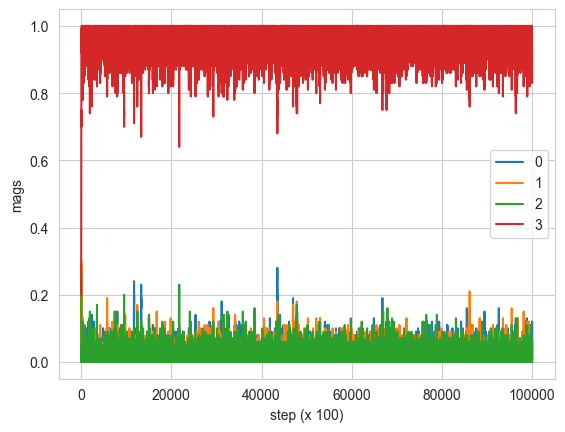

In [42]:
mag_history = mag_historys[t]

max_mag = mag_history.max(axis=1) / N
print(f"Average magnetization: {max_mag.mean()}")

# print magnetization evolution in time
for i in range(q):
    plt.plot(mag_historys[t][:, i] / N, label=i)
plt.xlabel(f'step (x {stride})')
plt.ylabel('mags')
plt.legend()
plt.show()

As expected, the system polarizes and the dominant state remains the same for the whole simulation, just like we observed keeping a higher temperature but increasing the size of the system.

Finally, let's see the behaviour of the system when the temperature is higher than the critical temperature. First, let's simulate the small system.

In [39]:
L = 10
N = L ** 2
q = 4
t = 0.95
nstep = 10 ** 7
burnin = 0
stride = 100

MCMC(L, q, t, nstep, burnin, J, stride)

Average magnetization: 0.6678113999999999


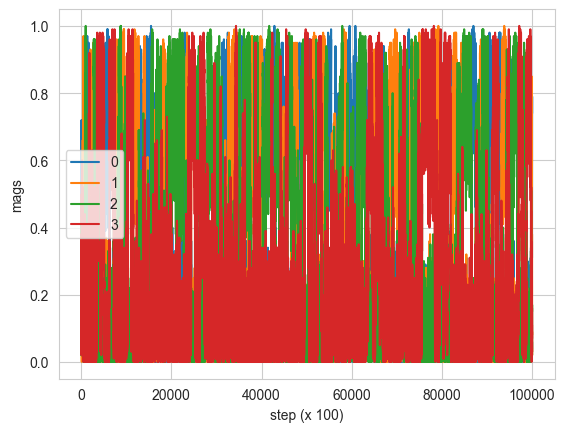

In [40]:
mag_history = mag_historys[t]

max_mag = mag_history.max(axis=1) / N
print(f"Average magnetization: {max_mag.mean()}")

# print magnetization evolution in time
for i in range(q):
    plt.plot(mag_historys[t][:, i] / N, label=i)
plt.xlabel(f'step (x {stride})')
plt.ylabel('mags')
plt.legend()
plt.show()

In this case, we see that the chain explores the configuration space in a very noisy way. Since the system is small, thermal fluctuations frequently bring the system in a polarized state, but the order is immediately distructed. Entropy wins the trade-off with energy.

Let's see what happens with the same temperature, but a larger system.

In [36]:
L = 30
N = L ** 2
q = 4
t = 0.95
nstep = 10 ** 7
burnin = 0
stride = 100

MCMC(L, q, t, nstep, burnin, J, stride)

Average magnetization: 0.37278202222222223


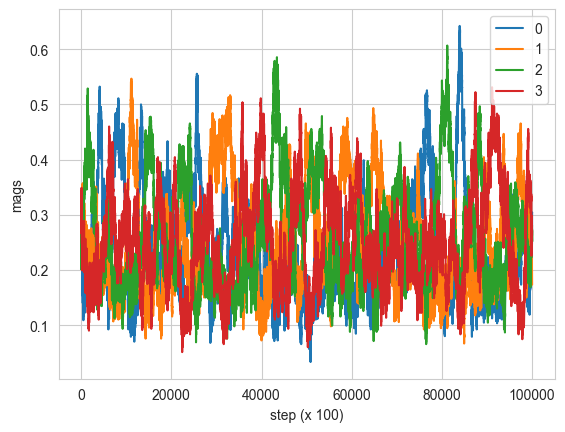

In [38]:
mag_history = mag_historys[t]

max_mag = mag_history.max(axis=1) / N
print(f"Average magnetization: {max_mag.mean()}")

# print magnetization evolution in time
for i in range(q):
    plt.plot(mag_historys[t][:, i] / N, label=i)
plt.xlabel(f'step (x {stride})')
plt.ylabel('mags')
plt.legend()
plt.show()

Increasing the size of the system made the energy barrier between oppositely polarized states larger. The system still explores the state space in a very noisy way, but the width of the fluctuations in terms of magnetization is smaller since the barriers got larger.

One last remark, before moving on to the experiments. We saw here that the size of the system plays a role in shaping the behaviour of the chain, and can also have an effect on the thermodynamic averages (for instance, in the last example, bringing L from 10 to 30 changed the average magnetization from 0.67 to 0.37). The theoretical analysis of the model, instead, is always carried out in the limit of an infinitely large system. For this reason, to detect the phase transition, we simulated the system using increasing values of $L$ until the thermodynamic averages stopped changing significantly in response to a change in $L$. We found that, for this system, already using as few as 400 spins provides a good approximation of the thermodynamic limit (although we managed to go much higher in our experiments, up 2500 spins, thanks to the optimizations in the code that we described in the previous section).

# Phase Transitions

Now, we present the results of our simulations. We considered different values of for $q$ and for $L$. For each pair, we used the Metropolis Hastings algorithm to estimate the thermodynamic averages of energy and magnetization for a range of different temperatures. We sampled more densely around the critical temperature, since that is where most of the action takes place. Furthermore, to ensure convergence of the simulations while keeping the overall computing time manageable, we used a different number of steps depending on the distance from the critical temperature, since we noticed that it had an influence on the equilibration time.
We are going to load the results from a json, since running the simulations again would take hours.

In [32]:
from dataclasses import dataclass
import os, json
import matplotlib.pyplot as plt


def load(q, L, file_name="simulation"):
    with open(os.path.join("results", f"{file_name}_{q=}_{L=}.json")) as f:  # change this
        d = json.load(f)
    for key in d.keys():
        d[key] = d[key][1:]
    return d.values()

@dataclass
class Experiment:
    temps: list
    avg_en: list
    avg_mag: list
    spec_heat: list
    spec_heat_temps: list


exps: dict[tuple[int, int]: Experiment] = {}

In [33]:
# Loading the data from the json files

qs = [2, 3, 4, 5, 8]
Ls = [10, 20, 30, 50]
for q in qs:
    for L in Ls:
        try:  # not all the combinations have been simulated
            exps[q, L] = Experiment(*load(q, L))
        except FileNotFoundError:
            pass

We can start by plotting the energy against the temperature for different values of $q$, keeping $L$ fixed.

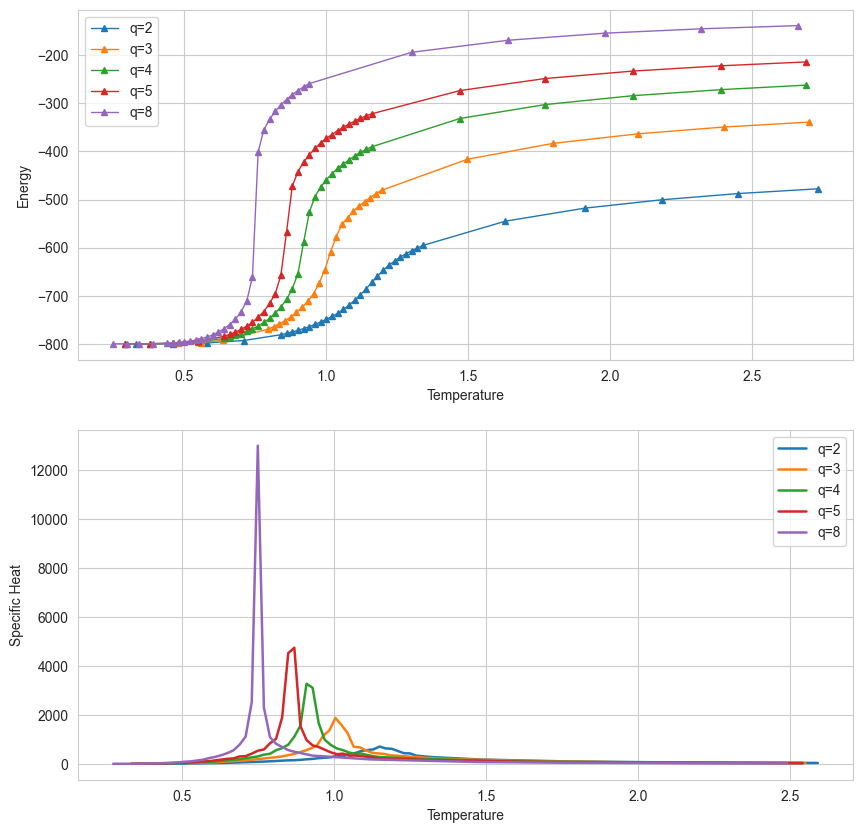

In [34]:
L = 20
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

for q in qs:
    ax[0].plot(exps[q, L].temps, exps[q, L].avg_en, label=f"q={q}", marker="^", markersize=5, linewidth=1)

    ax[1].plot(exps[q, L].spec_heat_temps, exps[q, L].spec_heat, label=f"q={q}", marker="", markersize=5, linewidth=1.8)

ax[0].legend()
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel("Energy")

ax[1].legend()
ax[1].set_xlabel("Temperature")
ax[1].set_ylabel("Specific Heat")

plt.show()

First of all, we observe a phase transition for all the tested values of $q$. The energy increase is steeper and steeper as $q$ increases. For $q = 2, 3$, the transition is visibly continuous; for $q = 8$ the change in energy is extremely abrupt, with a discontinuous transition. However, from this plot alone it is hard to tell whether there is a qualitative difference between $q=4$ and $q=5$. We will investigate this aspect further in the following.
Furthermore, notice that, as expected from the theoretical predictions (see graph in previous section), the location of the transition on the temperature axis shifts towards the left as $q$ increases.

Of course, the theoretical results are valid in the thermodynamic limit, while these simulations consider a finite lattice. To check whether there are any significant finite-size effects at play, we now plot the energy vs temperature curve for different values of $L$, at fixed $q$.

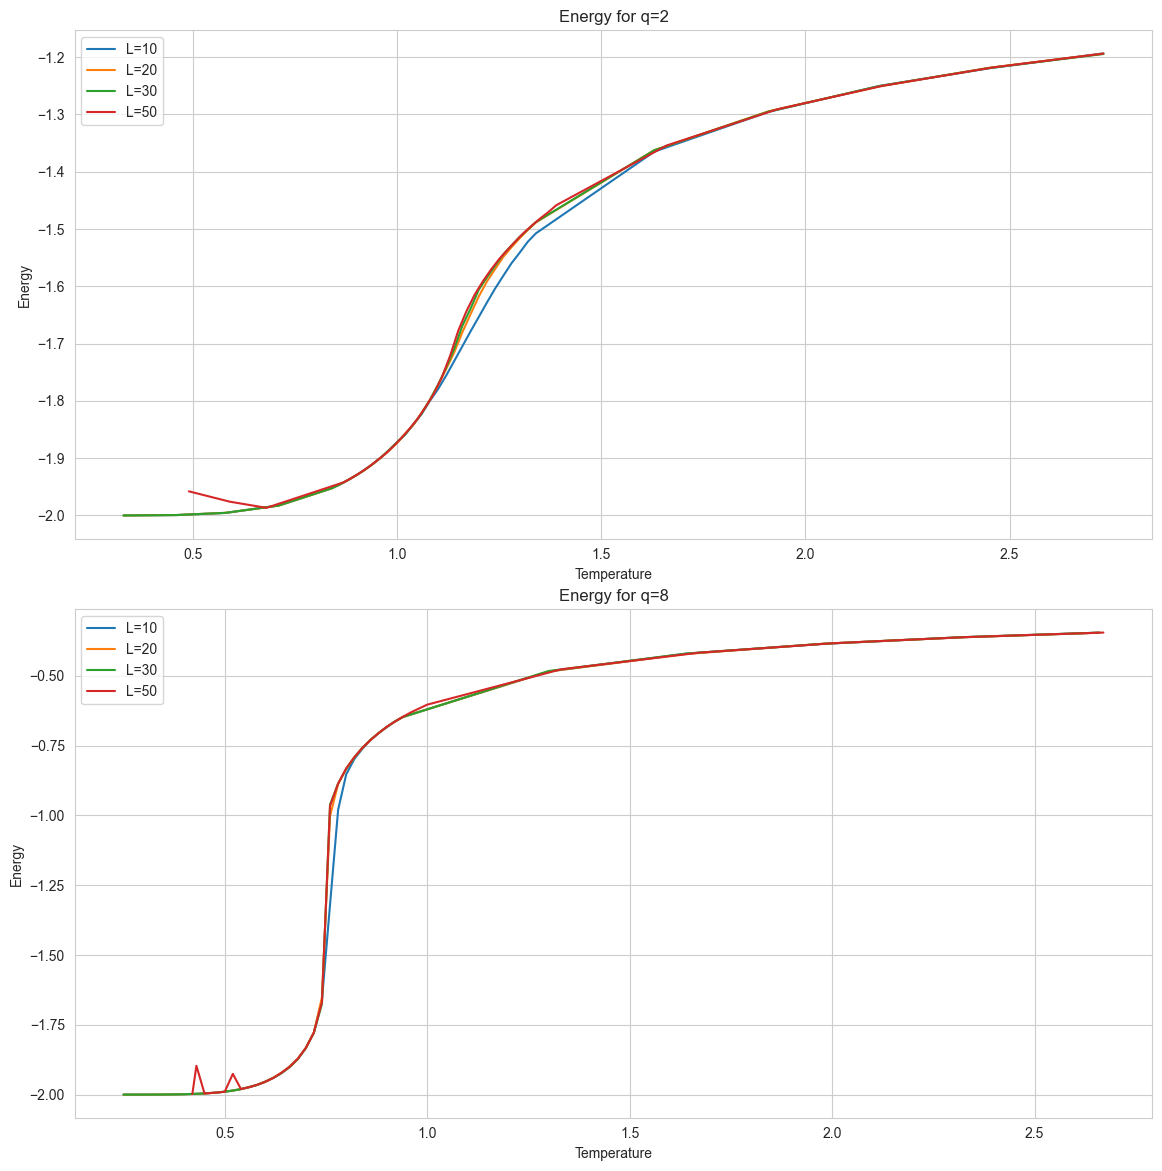

In [35]:
import numpy as np

q_1 = [2, 8]
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
fig.tight_layout(pad=3.0)
for i, q in enumerate(q_1):
    for L in Ls:
        # We divide by L^2 in order to have all the energies on the same order of magnitude

        ax[i].plot(exps[q, L].temps, np.array(exps[q, L].avg_en) / L ** 2, label=f"L={L}")

    ax[i].legend()
    ax[i].set_xlabel("Temperature")
    ax[i].set_ylabel("Energy")
    ax[i].set_title(f"Energy for q={q}")

# plt.grid()

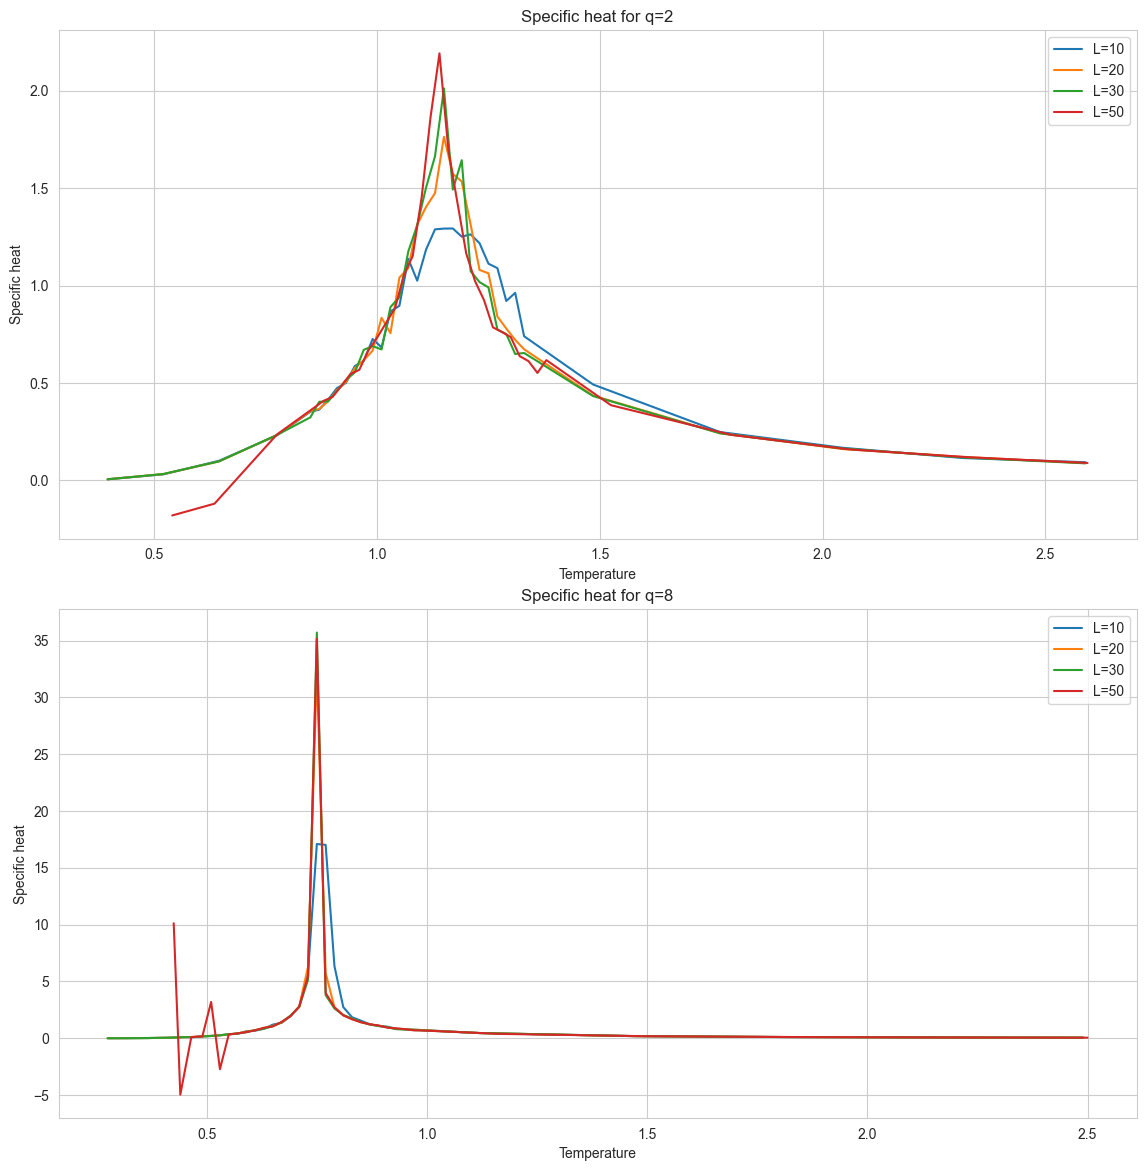

In [36]:
# do the same as the previous cell but with the specific heat
q_1 = [2, 8]
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
fig.tight_layout(pad=3.0)
for i, q in enumerate(q_1):
    for L in Ls:
        ax[i].plot(exps[q, L].spec_heat_temps , np.array(exps[q, L].spec_heat) / L ** 2, label=f"L={L}")

    ax[i].legend()
    ax[i].set_xlabel("Temperature")
    ax[i].set_ylabel("Specific heat")
    ax[i].set_title(f"Specific heat for q={q}")
    # ax[i].grid()


As we can observe, the curves of the energy are almost identical both for $q=2$ and $q=8$ (with a small deviation for $L =10$). For the specific heat we can note that for $L=10$ there are some finite-size effects, which, however, seem to be negligible for $L\ge20$.
In the case $q=8$ we observe some instability for small temperatures: although this could be fixed by running the simulation for longer, it is not tremendously interesting to do so as it is far from the phase transition.

In the following, we systematically plot all the thermodynamics averages against temperature, to provide a complete picture of the phase transition phenomena. We begin with the energy, which we have already commented.

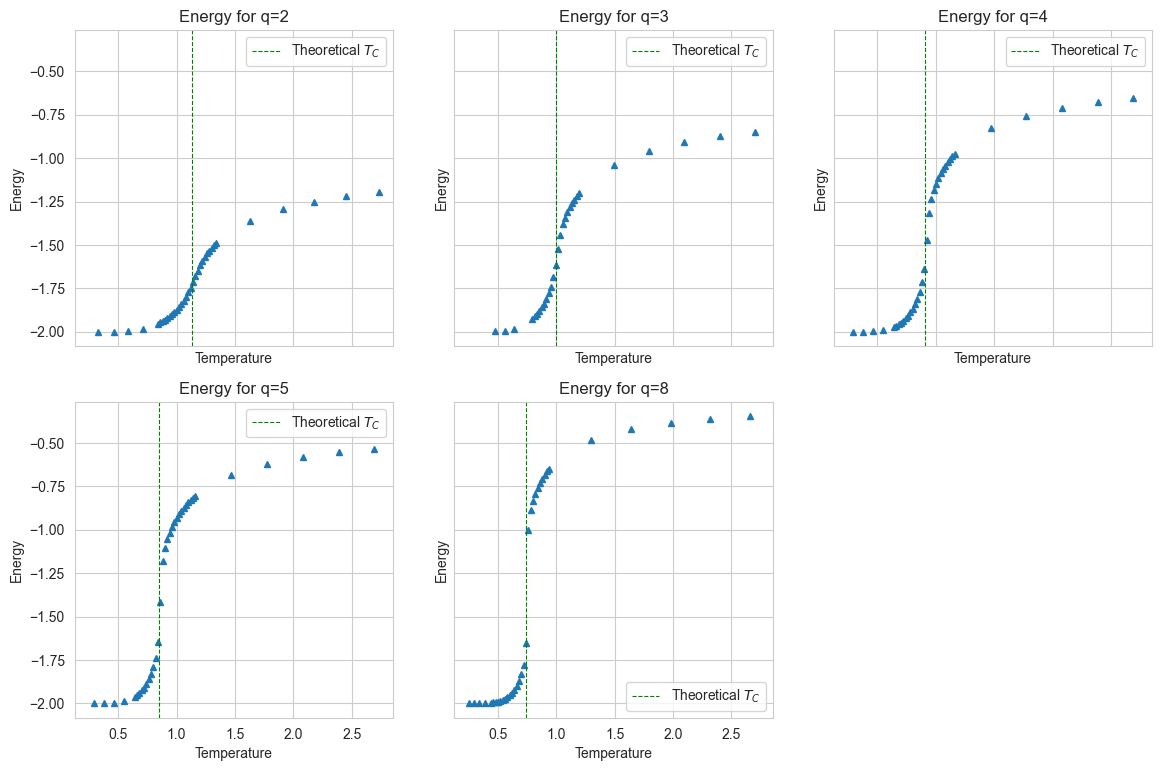

In [47]:
L = 20
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True)
fig.tight_layout(pad=3.0)
for i, q in enumerate(qs):
    ax_current = ax[i // 3, i % 3]
    ax_current.plot(exps[q, L].temps, np.array(exps[q, L].avg_en) / L ** 2, marker="^",
                    linestyle="", markersize=4)

    ax_current.axvline(critical_Temperature(q), color="green", linestyle="--", label=r"Theoretical $T_C$", linewidth=.8)

    # ax[i // 2, i % 2].legend()
    ax_current.set_xlabel("Temperature")
    ax_current.set_ylabel("Energy")
    ax_current.set_title(f"Energy for q={q}")
    ax_current.legend()

fig.delaxes(ax[1,2])

From the energy estimates, we can compute the specific heat using finite differences (see 'code for simulations' section for details). The results are the following:

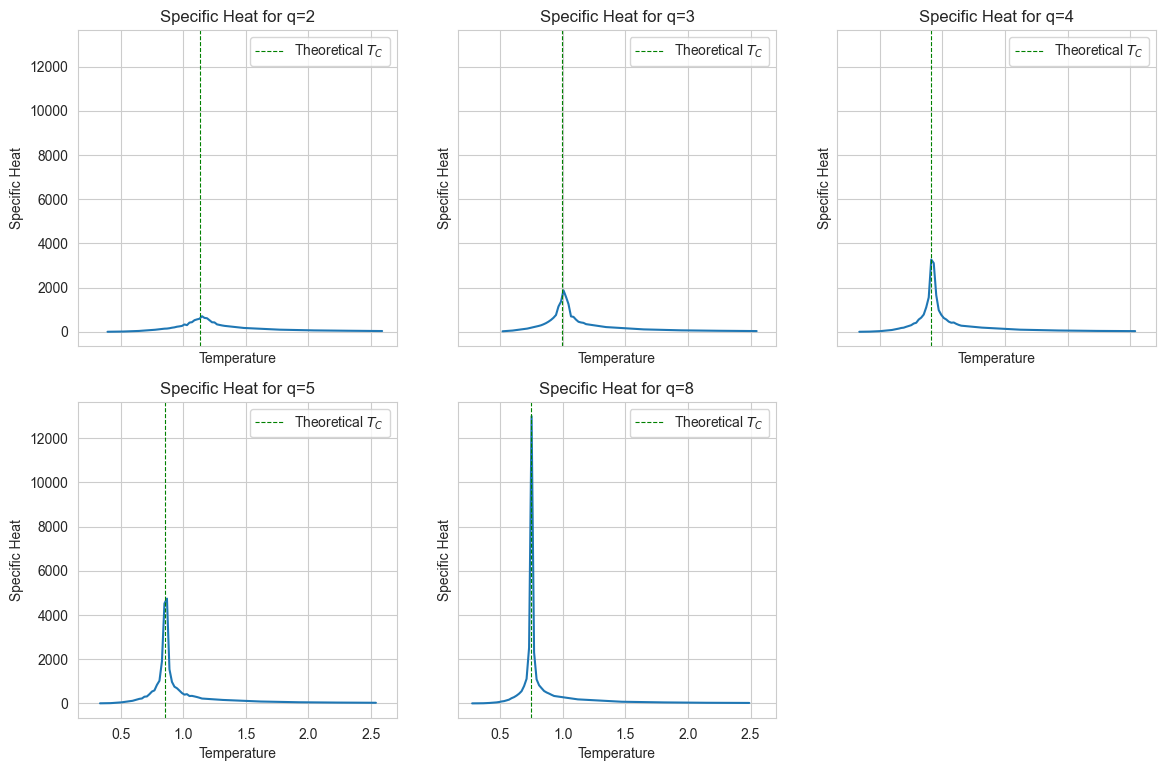

In [48]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True)
fig.tight_layout(pad=3.0)
for i, q in enumerate(qs):
    ax_current = ax[i // 3, i % 3]
    ax_current.plot(exps[q, L].spec_heat_temps, exps[q, L].spec_heat)

    ax_current.axvline(critical_Temperature(q), color="green", linestyle="--", label=r"Theoretical $T_C$", linewidth=.8)

    # ax[i // 2, i % 2].legend()
    ax_current.set_xlabel("Temperature")
    ax_current.set_ylabel("Specific Heat")
    ax_current.set_title(f"Specific Heat for q={q}")
    ax_current.legend()

plt.grid()
fig.delaxes(ax[1,2])

As we can see, the specific heat has a peak at the critical temperature, which is in agreement with the theoretical predictions. The peak is much more pronounced for higher values of $q$. To better differentiate between the cases $q=4$ and $q=5$, we can zoom into the region around the peak.

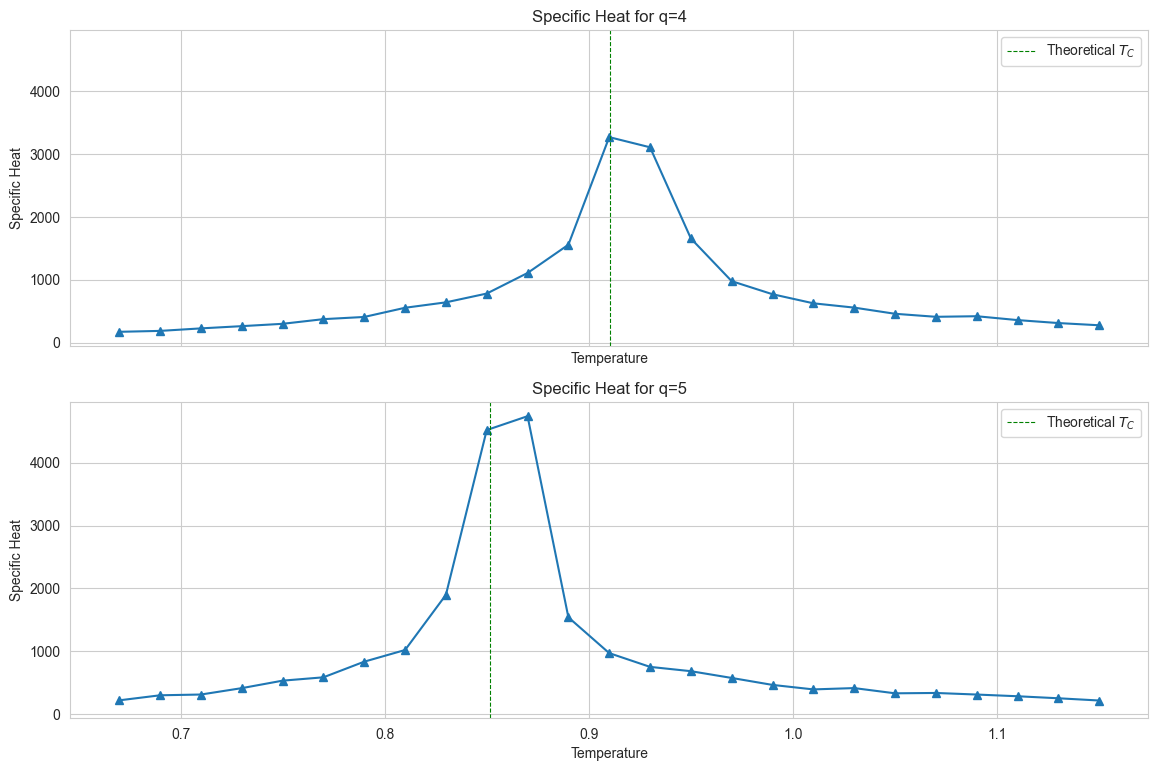

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharey=True, sharex=True)
fig.tight_layout(pad=3.0)

for i, q in enumerate([4,5]):
    ax_current = ax[i]
    ax_current.plot(exps[q, L].spec_heat_temps[5:-5], exps[q, L].spec_heat[5:-5], marker="^")

    ax_current.axvline(critical_Temperature(q), color="green", linestyle="--", label=r"Theoretical $T_C$", linewidth=.8)

    # ax[i // 2, i % 2].legend()
    ax_current.set_xlabel("Temperature")
    ax_current.set_ylabel("Specific Heat")
    ax_current.set_title(f"Specific Heat for q={q}")
    ax_current.legend()

# plt.grid()

We see that, indeed, the case $q=5$ has a significantly more pronounced peak. Whether this signals a qualitative change due to a different nature of the phase transition, or simply a similar effect to what is observed for instance passing from $q=2$ to $q=3$, is hard to tell from these graphs alone (although we know from the theory that there is in fact a qualitative difference).

Now, we plot the magnetization. As we already mentioned, this is computed as the fraction of spins that occupy the most abundant state at any given time.

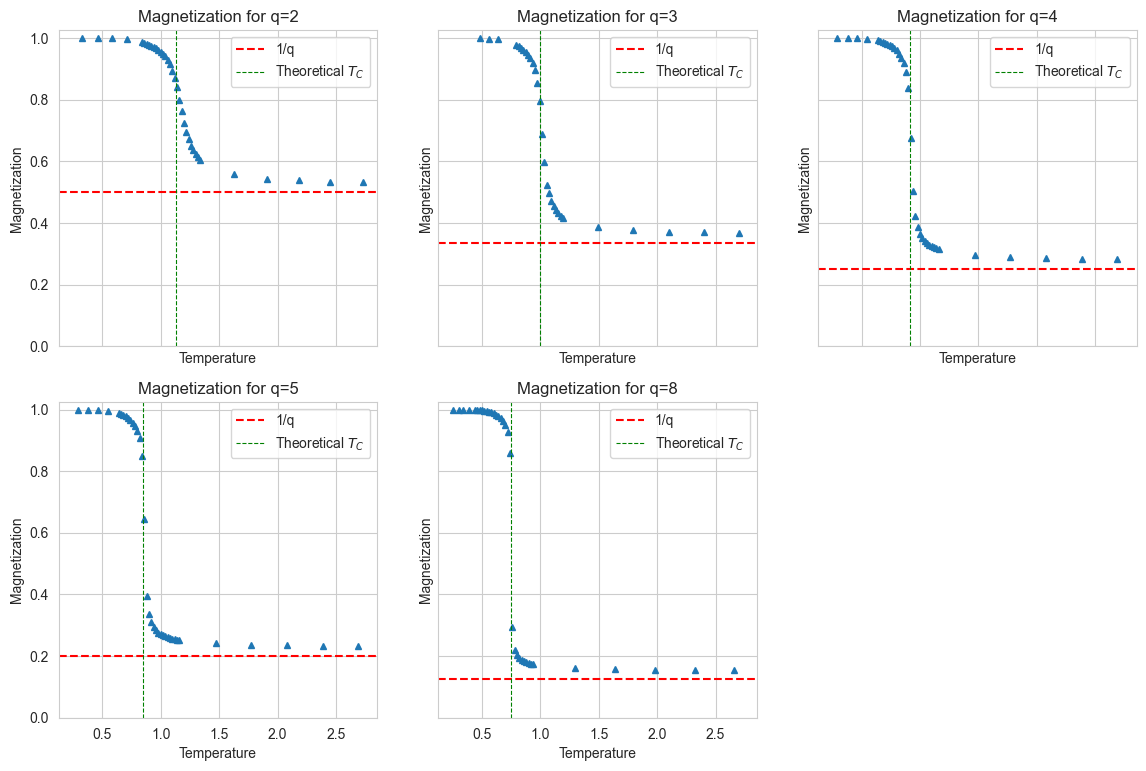

In [50]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True, sharex=True)
fig.tight_layout(pad=3.0)
for i, q in enumerate(qs):
    ax_current = ax[i // 3, i % 3]
    ax_current.plot(exps[q, L].temps, exps[q, L].avg_mag, marker="^", linestyle="", markersize=4)

    ax_current.axhline(1 / q, color="red", linestyle="--", label="1/q")
    ax_current.axvline(critical_Temperature(q), color="green", linestyle="--", label=r"Theoretical $T_C$", linewidth=.8)

    ax_current.legend()

    ax_current.set_xlabel("Temperature")
    ax_current.set_ylabel("Magnetization")
    ax_current.set_ylim(0)
    ax_current.set_title(f"Magnetization for q={q}")

plt.grid()
fig.delaxes(ax[1,2])


The conclusions are very similar as for the energy: there is a transition whose location is in excellent agreement with the theoretical critical temperature. The transition becomes discontinuous for $q > 4$, while it is continuous for $q \le 4$, with the same remarks on the difference between $q=4$ and $q=5$. Finally, to try and shed a light on this difference, we repeated the simulation with values of the temperature extremely close to the critical temperature. This of course required using more iterations to obtain stable results. The zoom in is plotted below.

In [51]:
# Loading the data from the json files
exps_zoom = dict()
qs_z = [4, 5]
L = 50
for q in qs_z:
    try:  # not all the combinations have been simulated
        exps_zoom[q, L] = Experiment(*load(q, L, file_name="zoom"))
        exps_zoom[q, L] = Experiment(*load(q, L, file_name="zoom"))
    except FileNotFoundError:
        pass

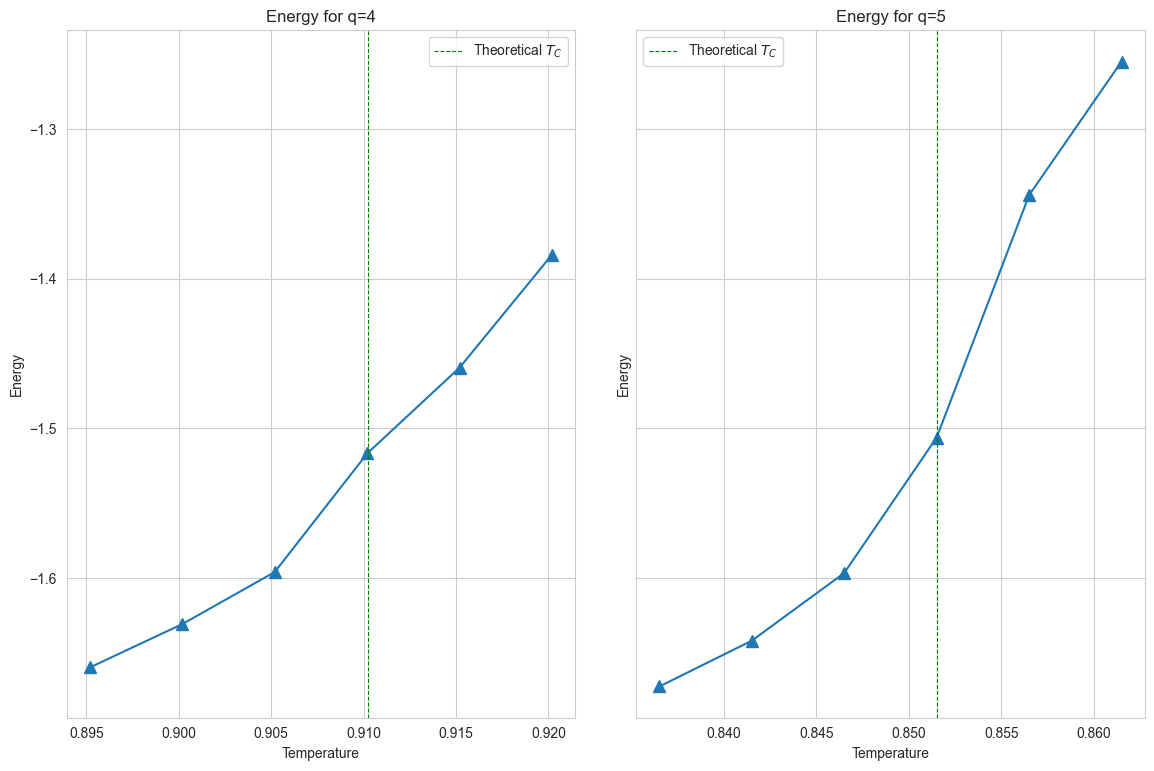

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, sharex=False)
fig.tight_layout(pad=3.0)
for i, q in enumerate(qs_z):
    ax_current = ax[i]
    ax_current.plot(exps_zoom[q, L].temps, np.array(exps_zoom[q, L].avg_en) / L ** 2, marker="^",
                    linestyle="-", markersize=8)

    # draw a green vertical line at the critical temperature for q
    ax_current.axvline(critical_Temperature(q), color="green", linestyle="--", label=r"Theoretical $T_C$", linewidth=.8)

    ax_current.set_xlabel("Temperature")
    ax_current.set_ylabel("Energy")
    ax_current.set_title(f"Energy for q={q}")
    ax_current.legend()


The case $q = 5$ appears significantly steeper. Seen at this level of detail, the curves seem to timidly confirm that the nature of the phase transition is indeed changing from continuous to discontinuous.

# Conclusions

Our study has shown that the Metropolis-Hastings algorithm is capable of effectively estimating the average energy and magnetization of the ferromagnetic 2d Potts model. The energy-temperature and magnetization-temperature curves exhibit a phase transition at the theoretical critical temperature, as suggested by the theory. Furthermore, visual inspection of the curves suggests that the order of the transitions was captured correctly, at least when $q < 4$ (continuous) or $q > 5$ (discontinuous). When $q = 4, 5$ we did notice a difference, although not as pronounced, suggesting that indeed there is a qualitatively different behaviour between the two cases. Finally, experiments scaling up the lattice size showed that already a $20 \times 20$ model gives estimates very close to the asymptotic ones.
